In [ ]:
import cv2
import numpy as np
import pywt
import itertools

class DWT:
    def __init__(self):
        self.message = None
        self.bitMess = None
        self.oriCol = 0
        self.oriRow = 0
        self.numBits = 0

    def encode_image(self, img, secret_msg):
        secret = secret_msg
        print("Secret message: ", secret)
        print("Length of secret message: ", len(secret))

        self.message = str(len(secret)) + '*' + secret
        self.bitMess = self.toBits()

        row, col = img.shape[:2]
        self.oriRow, self.oriCol = row, col

        if (col // 8) * (row // 8) < len(secret):
            print("Error: Message too large to encode in image")
            return False

        if row % 8 != 0 or col % 8 != 0:
            img = self.addPadd(img, row, col)

        row, col = img.shape[:2]

        bImg, gImg, rImg = cv2.split(img)
        bImg = np.float32(bImg)

        # **小波变换**
        coeffs = pywt.dwt2(bImg, 'haar')
        LL, (LH, HL, HH) = coeffs
        print("LL shape: ", LL.shape)
        # **在 LL（低频分量）中隐藏信息**
        messIndex = 0
        letterIndex = 0
        for i in range(LL.shape[0]):
            for j in range(LL.shape[1]):
                if messIndex < len(self.bitMess):
                    pixel = int(LL[i, j])
                    pixel = np.uint8(pixel)
                    pixel_bits = np.unpackbits(pixel)
                    pixel_bits[7] = self.bitMess[messIndex][letterIndex]
                    LL[i, j] = np.packbits(pixel_bits).astype(float)

                    letterIndex += 1
                    if letterIndex == 8:
                        letterIndex = 0
                        messIndex += 1
                        if messIndex == len(self.message):
                            break
            if messIndex == len(self.message):
                break

        # **逆小波变换**
        coeffs_hidden = (LL, (LH, HL, HH))
        bImg_stego = pywt.idwt2(coeffs_hidden, 'haar')

        # **合成最终的 RGB 图像**
        sImg = cv2.merge((np.uint8(bImg_stego), gImg, rImg))
        return sImg

    def decode_image(self, img):
        row, col = img.shape[:2]
        messSize = None
        messageBits = []
        buff = 0

        bImg, gImg, rImg = cv2.split(img)
        bImg = np.float32(bImg)

        # **小波变换**
        coeffs = pywt.dwt2(bImg, 'haar')
        LL, (LH, HL, HH) = coeffs
        
        # **提取信息**
        i = 0
        for row in range(LL.shape[0]):
            for col in range(LL.shape[1]):
                pixel = int(LL[row, col])
                pixel = np.uint8(pixel)
                pixel_bits = np.unpackbits(pixel)

                if pixel_bits[7] == 1:
                    buff += (0 & 1) << (7 - i)
                elif pixel_bits[7] == 0:
                    buff += (1 & 1) << (7 - i)

                i += 1
                if i == 8:
                    messageBits.append(chr(buff))
                    buff = 0
                    i = 0
                    if messageBits[-1] == '*' and messSize is None:
                        try:
                            messSize = int(''.join(messageBits[:-1]))
                        except:
                            pass
                if len(messageBits) - len(str(messSize)) - 1 == messSize:
                    return ''.join(messageBits)[len(str(messSize)) + 1:]

        return ''

    def addPadd(self, img, row, col):
        img = cv2.resize(img, (col + (8 - col % 8), row + (8 - row % 8)))
        return img

    def toBits(self):
        bits = []
        for char in self.message:
            binval = bin(ord(char))[2:].rjust(8, '0')
            bits.append(binval)
        self.numBits = bin(len(bits))[2:].rjust(8, '0')
        return bits

# **运行代码**
dwt = DWT()
image = cv2.imread("./dataset/cover.jpg")  # 载入图片
secret_message = "H!"
encoded_image = dwt.encode_image(image, secret_message)
cv2.imwrite("./results/stego_dwt.png", encoded_image)

# **解码信息**
decoded_message = dwt.decode_image(encoded_image)
print("Decoded Message: ", decoded_message)


Secret message:  H!
Length of secret message:  2
LL shape:  (1152, 1536)


/tmp/ipykernel_59814/787805792.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LL[i, j] = np.packbits(pixel_bits).astype(float)
/tmp/ipykernel_59814/787805792.py:88: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 285 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  pixel = np.uint8(pixel)
/tmp/ipykernel_59814/787805792.py:88: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 300 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  pixel = np.uint8(pixel)
/t

Decoded Message:  


LL shape: (4, 4)
LL:
 [[509.99997 509.99997   0.        0.     ]
 [509.99997 509.99997   0.        0.     ]
 [  0.        0.      509.99997 509.99997]
 [  0.        0.      509.99997 509.99997]]


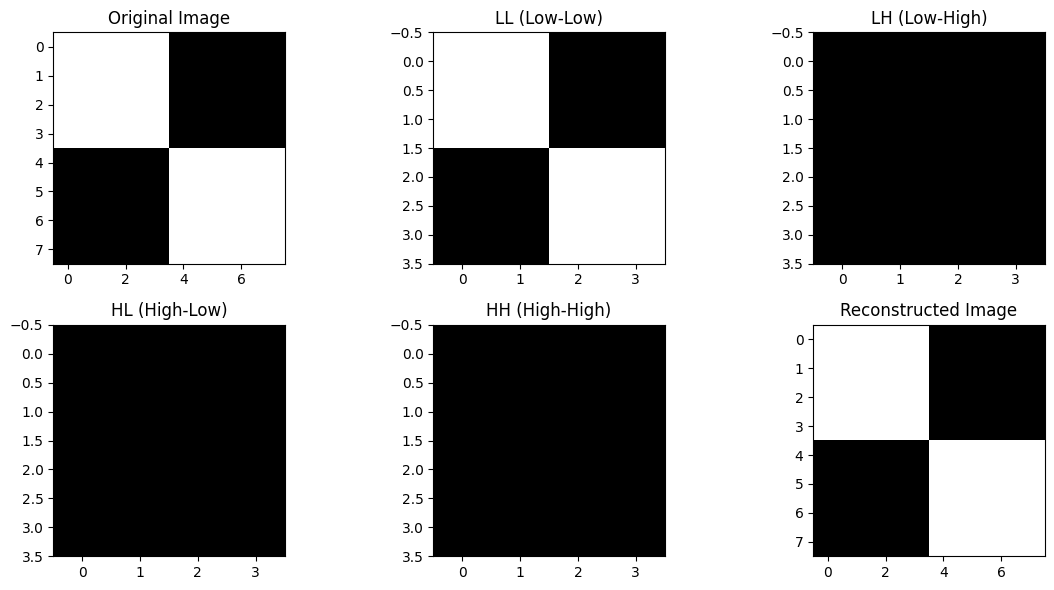

In [ ]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# 创建一个简单的图像（8x8矩阵）
image = np.array([
    [255, 255, 255, 255, 0, 0, 0, 0],
    [255, 255, 255, 255, 0, 0, 0, 0],
    [255, 255, 255, 255, 0, 0, 0, 0],
    [255, 255, 255, 255, 0, 0, 0, 0],
    [0, 0, 0, 0, 255, 255, 255, 255],
    [0, 0, 0, 0, 255, 255, 255, 255],
    [0, 0, 0, 0, 255, 255, 255, 255],
    [0, 0, 0, 0, 255, 255, 255, 255]
], dtype=np.float32)

# 执行一次 2D DWT（二维离散小波变换）
coeffs2 = pywt.dwt2(image, 'haar')  # 'haar' 是一种小波类型
LL, (LH, HL, HH) = coeffs2  # LL 是低频部分，LH, HL, HH 是高频部分
# 执行逆DWT（重建图像）
reconstructed_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
print("LL shape:", LL.shape)
print("LL:\n", LL)

# 输出各部分的图像
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 3, 2)
plt.imshow(LL, cmap='gray')
plt.title('LL (Low-Low)')

plt.subplot(2, 3, 3)
plt.imshow(LH, cmap='gray')
plt.title('LH (Low-High)')

plt.subplot(2, 3, 4)
plt.imshow(HL, cmap='gray')
plt.title('HL (High-Low)')

plt.subplot(2, 3, 5)
plt.imshow(HH, cmap='gray')
plt.title('HH (High-High)')

# 执行逆DWT（重建图像）
reconstructed_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')

plt.subplot(2, 3, 6)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')

plt.tight_layout()
plt.show()


In [ ]:
import os
import xlwt
import shutil
import cv2
import sys
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt


import cv2
import numpy as np
import itertools

# 拼接函数：将四个 4x4 的矩阵拼接成一个 8x8 矩阵
def merge_blocks(LL, LH, HL, HH):
    # 拼接 LL 和 LH
    top_row = np.hstack((LL, LH))
    # 拼接 HL 和 HH
    bottom_row = np.hstack((HL, HH))
    # 纵向拼接两行，得到最终的 8x8 矩阵
    final_matrix = np.vstack((top_row, bottom_row))
    return final_matrix

# 分裂函数：将一个 8x8 的矩阵分裂成四个 4x4 的块
def split_blocks(matrix):
    # 确保输入矩阵是 8x8 的
    if matrix.shape != (8, 8):
        raise ValueError("输入矩阵必须是 8x8 的！")
    
    # 分裂矩阵，获取 4x4 的块
    LL = matrix[:4, :4]
    LH = matrix[:4, 4:]
    HL = matrix[4:, :4]
    HH = matrix[4:, 4:]
    
    return LL, LH, HL, HH 

#from scipy import signal
quant = np.array([[16,11,10,16,24,40,51,61],      # QUANTIZATION TABLE
                    [12,12,14,19,26,58,60,55],    # required for DCT
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])
        

class DCT():    
    def __init__(self): # Constructor
        self.message = None
        self.bitMess = None
        self.oriCol = 0
        self.oriRow = 0
        self.numBits = 0  

    #encoding part : 
    def encode_image(self,img,secret_msg):
        #show(img)
        secret=secret_msg
        self.message = str(len(secret))+'*'+secret
        self.bitMess = self.toBits()
        #get size of image in pixels
        row,col = img.shape[:2]
        ##col, row = img.size
        self.oriRow, self.oriCol = row, col  
        if((col/8)*(row/8)<len(secret)):
            print("Error: Message too large to encode in image")
            return False
        #make divisible by 8x8
        if row%8 != 0 or col%8 != 0:
            img = self.addPadd(img, row, col)
        
        row,col = img.shape[:2]
        ##col, row = img.size
        #split image into RGB channels
        bImg,gImg,rImg = cv2.split(img)
        #message to be hid in blue channel so converted to type float32 for dct function
        bImg = np.float32(bImg)
        #break into 8x8 blocks
        imgBlocks = [np.round(bImg[j:j+8, i:i+8]-128) for (j,i) in itertools.product(range(0,row,8),
                                                                       range(0,col,8))]
        #Blocks are run through DCT function
        dctBlocks = [np.round(cv2.dct(img_Block)) for img_Block in imgBlocks]
        # print("single dct block shape:",dctBlocks[0].shape)

        dctBlocks=[]
        for img_Block in imgBlocks:
            # 执行一次 2D DWT（二维离散小波变换）
            coeffs2 = pywt.dwt2(img_Block, 'haar')  # 'haar' 是一种小波类型
            LL, (LH, HL, HH) = coeffs2  # LL 是低频部分，LH, HL, HH 是高频部分

            # reconstructed_image = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
            dctBlocks.append(merge_blocks(LL, LH, HL, HH))
        # print("single dct block shape:",dctBlocks[0].shape)

        #blocks then run through quantization table
        quantizedDCT = [np.round(dct_Block/quant) for dct_Block in dctBlocks]
        #set LSB in DC value corresponding bit of message
        messIndex = 0
        letterIndex = 0
        for quantizedBlock in quantizedDCT:
            #find LSB in DC coeff and replace with message bit
            DC = quantizedBlock[0][0]
            DC = np.uint8(DC)
            DC = np.unpackbits(DC)
            DC[7] = self.bitMess[messIndex][letterIndex]
            DC = np.packbits(DC)
            DC = np.float32(DC)
            DC= DC-255
            quantizedBlock[0][0] = DC
            letterIndex = letterIndex+1
            if letterIndex == 8:
                letterIndex = 0
                messIndex = messIndex + 1
                if messIndex == len(self.message):
                    break
        #blocks run inversely through quantization table
        sImgBlocks = [quantizedBlock *quant+128 for quantizedBlock in quantizedDCT]
        #blocks run through inverse DCT
        #sImgBlocks = [cv2.idct(B)+128 for B in quantizedDCT]
        #puts the new image back together
        sImg=[]
        for chunkRowBlocks in self.chunks(sImgBlocks, col/8):
            for rowBlockNum in range(8):
                for block in chunkRowBlocks:
                    sImg.extend(block[rowBlockNum])
        sImg = np.array(sImg).reshape(row, col)
        #converted from type float32
        sImg = np.uint8(sImg)
        #show(sImg)
        sImg = cv2.merge((sImg,gImg,rImg))
        return sImg

    #decoding part :
    def decode_image(self,img):
        row,col = img.shape[:2]
        messSize = None
        messageBits = []
        buff = 0
        #split image into RGB channels
        bImg,gImg,rImg = cv2.split(img)
         #message hid in blue channel so converted to type float32 for dct function
        bImg = np.float32(bImg)
        #break into 8x8 blocks
        imgBlocks = [bImg[j:j+8, i:i+8]-128 for (j,i) in itertools.product(range(0,row,8),
                                                                       range(0,col,8))]    
        #blocks run through quantization table
        #quantizedDCT = [dct_Block/ (quant) for dct_Block in dctBlocks]
        quantizedDCT = [img_Block/quant for img_Block in imgBlocks]
        i=0
        #message extracted from LSB of DC coeff
        for quantizedBlock in quantizedDCT:
            DC = quantizedBlock[0][0]
            DC = np.uint8(DC)
            DC = np.unpackbits(DC)
            if DC[7] == 1:
                buff+=(0 & 1) << (7-i)
            elif DC[7] == 0:
                buff+=(1&1) << (7-i)
            i=1+i
            if i == 8:
                messageBits.append(chr(buff))
                buff = 0
                i =0
                if messageBits[-1] == '*' and messSize is None:
                    try:
                        messSize = int(''.join(messageBits[:-1]))
                    except:
                        pass
            if len(messageBits) - len(str(messSize)) - 1 == messSize:
                return ''.join(messageBits)[len(str(messSize))+1:]
        #blocks run inversely through quantization table
        sImgBlocks = [quantizedBlock *quant+128 for quantizedBlock in quantizedDCT]
        #blocks run through inverse DCT
        #sImgBlocks = [cv2.idct(B)+128 for B in quantizedDCT]
        #puts the new image back together
        sImg=[]
        for chunkRowBlocks in self.chunks(sImgBlocks, col/8):
            for rowBlockNum in range(8):
                for block in chunkRowBlocks:
                    sImg.extend(block[rowBlockNum])
        sImg = np.array(sImg).reshape(row, col)
        #converted from type float32
        sImg = np.uint8(sImg)
        sImg = cv2.merge((sImg,gImg,rImg))
        ##sImg.save(img)
        #dct_decoded_image_file = "dct_" + original_image_file
        #cv2.imwrite(dct_decoded_image_file,sImg)
        return ''
      
    """Helper function to 'stitch' new image back together"""
    def chunks(self, l, n):
        m = int(n)
        for i in range(0, len(l), m):
            yield l[i:i + m]
    def addPadd(self,img, row, col):
        img = cv2.resize(img,(col+(8-col%8),row+(8-row%8)))    
        return img
    def toBits(self):
        bits = []
        for char in self.message:
            binval = bin(ord(char))[2:].rjust(8,'0')
            bits.append(binval)
        self.numBits = bin(len(bits))[2:].rjust(8,'0')
        return bits




import cv2
import itertools

dct = DCT()
image = cv2.imread("./dataset/cover.jpg")  # Load your image
secret_message = "H!"
encoded_image = dct.encode_image(image, secret_message)
cv2.imwrite("./results/stego.png", encoded_image)

# Decoding
decoded_message = dct.decode_image(encoded_image)
print("Decoded Message: ", decoded_message)


single dct block shape: (8, 8)
single dct block shape: (8, 8)


error: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:929: error: (-215:Assertion failed) !_img.empty() in function 'imwrite'


In [20]:
import numpy as np

# 假设 LL, LH, HL, HH 都是 4x4 的矩阵
LL = np.array([[509.99997, 509.99997,   0.,         0.],
               [509.99997, 509.99997,   0.,         0.],
               [0.,         0.,        509.99997, 509.99997],
               [0.,         0.,        509.99997, 509.99997]])

LH = np.array([[16, 11, 10, 16],
               [12, 12, 14, 19],
               [14, 13, 16, 24],
               [14, 17, 22, 29]])

HL = np.array([[8, 8, 8, 8],
               [8, 8, 8, 8],
               [8, 8, 8, 8],
               [8, 8, 8, 8]])

HH = np.array([[32, 32, 32, 32],
               [32, 32, 32, 32],
               [32, 32, 32, 32],
               [32, 32, 32, 32]])

# 拼接成 8x8 的矩阵
top_row = np.hstack((LL, LH))  # 将 LL 和 LH 横向拼接
bottom_row = np.hstack((HL, HH))  # 将 HL 和 HH 横向拼接

# 将两行纵向拼接，形成 8x8 的矩阵
final_matrix = np.vstack((top_row, bottom_row))

print("8x8 拼接后的矩阵：")
print(final_matrix)


8x8 拼接后的矩阵：
[[509.99997 509.99997   0.        0.       16.       11.       10.
   16.     ]
 [509.99997 509.99997   0.        0.       12.       12.       14.
   19.     ]
 [  0.        0.      509.99997 509.99997  14.       13.       16.
   24.     ]
 [  0.        0.      509.99997 509.99997  14.       17.       22.
   29.     ]
 [  8.        8.        8.        8.       32.       32.       32.
   32.     ]
 [  8.        8.        8.        8.       32.       32.       32.
   32.     ]
 [  8.        8.        8.        8.       32.       32.       32.
   32.     ]
 [  8.        8.        8.        8.       32.       32.       32.
   32.     ]]
